
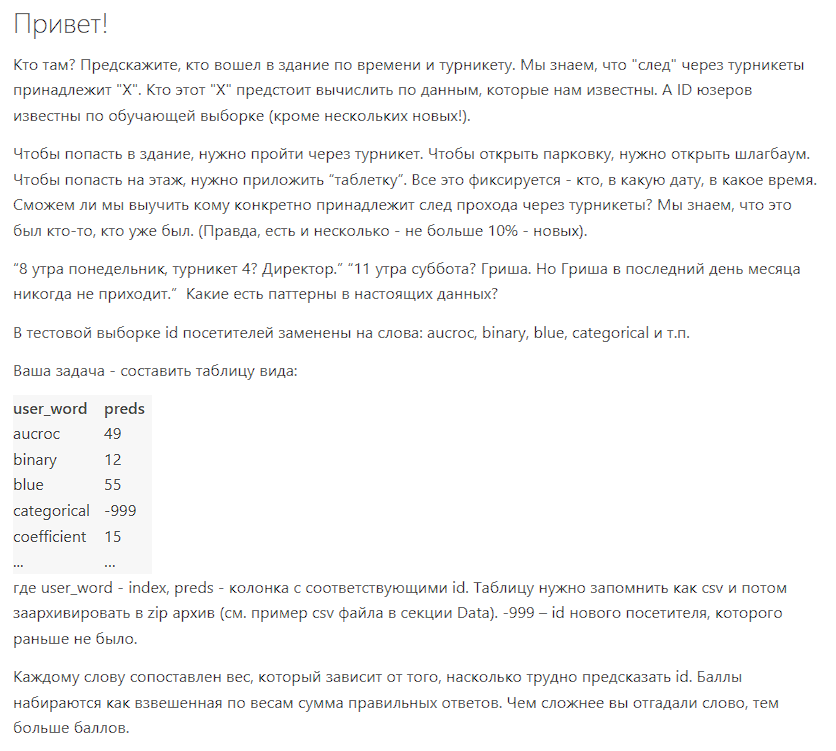

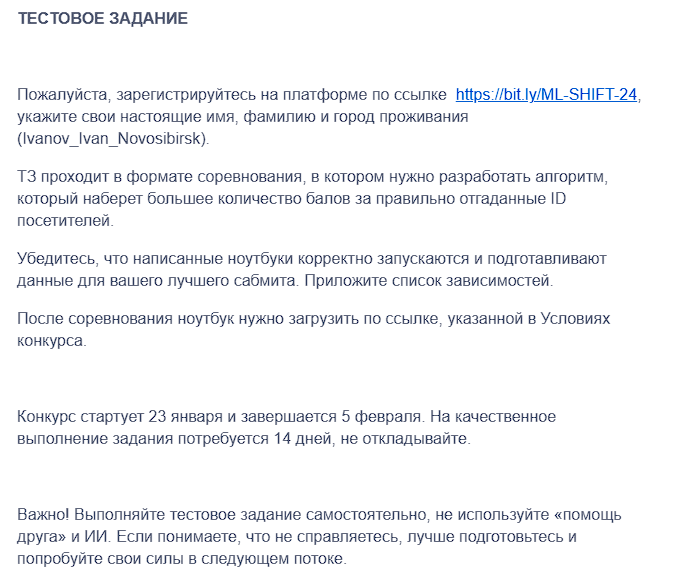

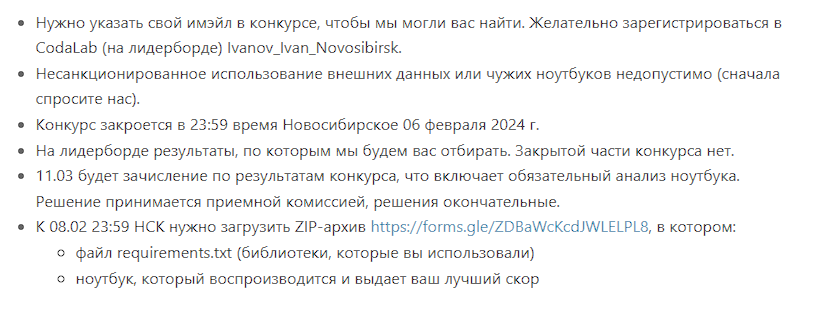

Импорт необходимых библиотек

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

Зашрузка данных и их первичный анализ

In [2]:
submit = pd.read_csv('submit.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [3]:
def pass_value_barh(df):
    """
    Функция для наглядного представления пропусков в данных
    """
    try:
        (
            (df.isna().sum())
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Пример' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось ')
checklist = ['submit', 'test', 'train']
for name in checklist:
    pass_value_barh(name)

пропусков не осталось 
пропусков не осталось 
пропусков не осталось 


Выведем информацию о данных

In [4]:
print(submit.info(), end = '\n')
print(test.info(), end = '\n')
print(train.info(), end = '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_word  34 non-null     object
 1   preds      34 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 672.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7125 entries, 0 to 7124
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  7125 non-null   int64 
 1   ts          7125 non-null   object
 2   gate_id     7125 non-null   int64 
 3   user_word   7125 non-null   object
dtypes: int64(2), object(2)
memory usage: 222.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37518 entries, 0 to 37517
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  37518 non-null  int64 
 1   user_id     37518 non-null  int64 
 2   ts    

In [5]:
print('Количество дубликатов в "data_1": ', test.duplicated().sum())
print('Количество дубликатов в "data_2": ', train.duplicated().sum())

Количество дубликатов в "data_1":  0
Количество дубликатов в "data_2":  0


Посмотрим на распределение целевого признака в train

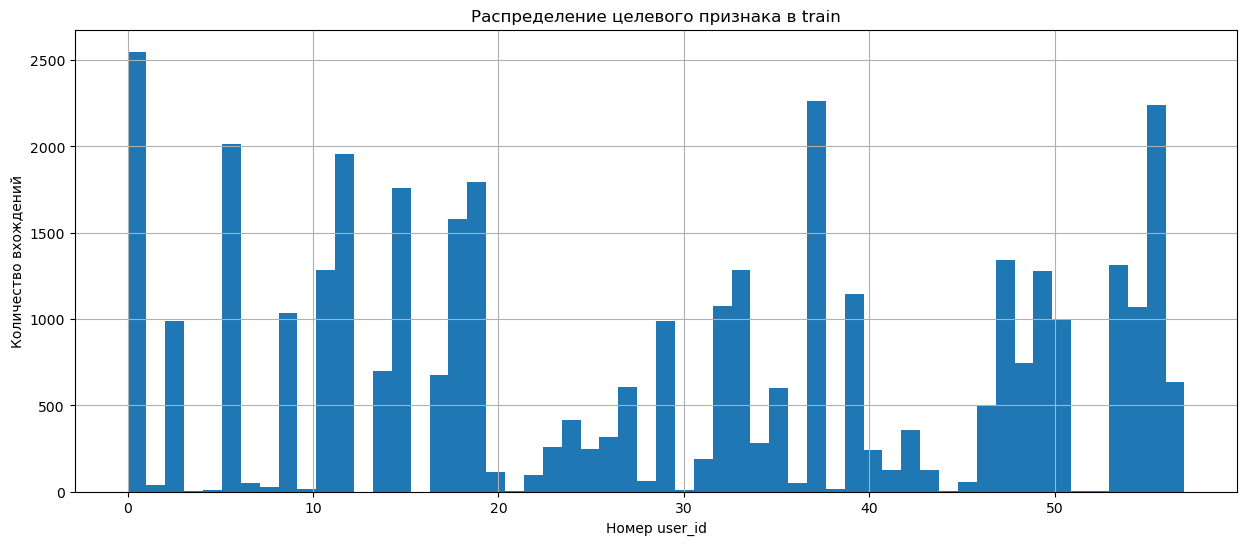

In [6]:
train.user_id.hist(bins=train.user_id.nunique(), figsize = (15, 6))
plt.title('Распределение целевого признака в train')
plt.xlabel('Номер user_id')
plt.ylabel('Количество вхождений')
plt.show()

Добавление новых признаков

In [7]:
def process_timestamp(df, timestamp_column='ts'):
    """
    Добавление новых признаков на основе признака 'ts'
    """
    df['date'] = df['ts'].dt.date # приведение к нормальному типу данных
    df['day'] = df[timestamp_column].dt.day # Извлечение дня месяца
    df['hour'] = df[timestamp_column].dt.hour # Извлечение часа
    df['minute'] = df[timestamp_column].dt.minute # Извлечение минут
    df['second'] = df[timestamp_column].dt.second # Извлечение секунд
    df['minutes'] = df['hour'] * 60 + df['minute'] # Расчет времени в минутах от начала дня
    df['seconds'] = df['minutes'] * 60 + df['second'] # Расчет времени в секундах от начала дня
    df['week'] = df[timestamp_column].dt.isocalendar().week # Извлечение номера недели
    df['month'] = df[timestamp_column].dt.month # Извлечение номера месяца
    df['weekday'] = df[timestamp_column].dt.weekday + 1 # Извлечение дня недели (1-понедельник, ..., 7-воскресенье)
train['ts'] = pd.to_datetime(train['ts'])
test['ts'] = pd.to_datetime(test['ts'])
process_timestamp(train)
process_timestamp(test)

In [8]:
train, test = train.drop('Unnamed: 0', axis = 1), test.drop('Unnamed: 0', axis = 1)

Посмотрим на наши данные с новыми признаками

In [9]:
print(train.info())
print(train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37518 entries, 0 to 37517
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   user_id  37518 non-null  int64         
 1   ts       37518 non-null  datetime64[ns]
 2   gate_id  37518 non-null  int64         
 3   date     37518 non-null  object        
 4   day      37518 non-null  int64         
 5   hour     37518 non-null  int64         
 6   minute   37518 non-null  int64         
 7   second   37518 non-null  int64         
 8   minutes  37518 non-null  int64         
 9   seconds  37518 non-null  int64         
 10  week     37518 non-null  UInt32        
 11  month    37518 non-null  int64         
 12  weekday  37518 non-null  int64         
dtypes: UInt32(1), datetime64[ns](1), int64(10), object(1)
memory usage: 3.6+ MB
None
(37518, 13)


In [10]:
print(test.info())
print(test.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7125 entries, 0 to 7124
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ts         7125 non-null   datetime64[ns]
 1   gate_id    7125 non-null   int64         
 2   user_word  7125 non-null   object        
 3   date       7125 non-null   object        
 4   day        7125 non-null   int64         
 5   hour       7125 non-null   int64         
 6   minute     7125 non-null   int64         
 7   second     7125 non-null   int64         
 8   minutes    7125 non-null   int64         
 9   seconds    7125 non-null   int64         
 10  week       7125 non-null   UInt32        
 11  month      7125 non-null   int64         
 12  weekday    7125 non-null   int64         
dtypes: UInt32(1), datetime64[ns](1), int64(9), object(2)
memory usage: 702.9+ KB
None
(7125, 13)


In [11]:
train

,user_id,ts,gate_id,date,day,hour,minute,second,minutes,seconds,week,month,weekday
0,18,2022-07-29 09:08:54,7,2022-07-29,29,9,8,54,548,32934,30,7,5
1,18,2022-07-29 09:09:54,9,2022-07-29,29,9,9,54,549,32994,30,7,5
2,18,2022-07-29 09:09:54,9,2022-07-29,29,9,9,54,549,32994,30,7,5
3,18,2022-07-29 09:10:06,5,2022-07-29,29,9,10,6,550,33006,30,7,5
4,18,2022-07-29 09:10:08,5,2022-07-29,29,9,10,8,550,33008,30,7,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37513,6,2022-12-31 20:38:56,11,2022-12-31,31,20,38,56,1238,74336,52,12,6
37514,6,2022-12-31 20:39:22,6,2022-12-31,31,20,39,22,1239,74362,52,12,6
37515,6,2022-12-31 20:39:23,6,2022-12-31,31,20,39,23,1239,74363,52,12,6
37516,6,2022-12-31 20:39:31,9,2022-12-31,31,20,39,31,1239,74371,52,12,6


In [12]:
test

,ts,gate_id,user_word,date,day,hour,minute,second,minutes,seconds,week,month,weekday
0,2023-01-03 08:21:00,9,gini,2023-01-03,3,8,21,0,501,30060,1,1,2
1,2023-01-03 08:21:00,9,gini,2023-01-03,3,8,21,0,501,30060,1,1,2
2,2023-01-03 08:21:18,5,gini,2023-01-03,3,8,21,18,501,30078,1,1,2
3,2023-01-03 08:21:19,5,gini,2023-01-03,3,8,21,19,501,30079,1,1,2
4,2023-01-03 08:21:39,10,gini,2023-01-03,3,8,21,39,501,30099,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7120,2023-02-24 19:43:36,11,collinear,2023-02-24,24,19,43,36,1183,71016,8,2,5
7121,2023-02-24 19:44:00,4,collinear,2023-02-24,24,19,44,0,1184,71040,8,2,5
7122,2023-02-24 19:44:01,4,collinear,2023-02-24,24,19,44,1,1184,71041,8,2,5
7123,2023-02-24 19:44:09,9,collinear,2023-02-24,24,19,44,9,1184,71049,8,2,5


Выделим из test признак к которму будем делать предсказания

In [13]:
test_user_word = pd.DataFrame(test.user_word)
test = test.drop('user_word', axis = 1)

Распределение по date в train

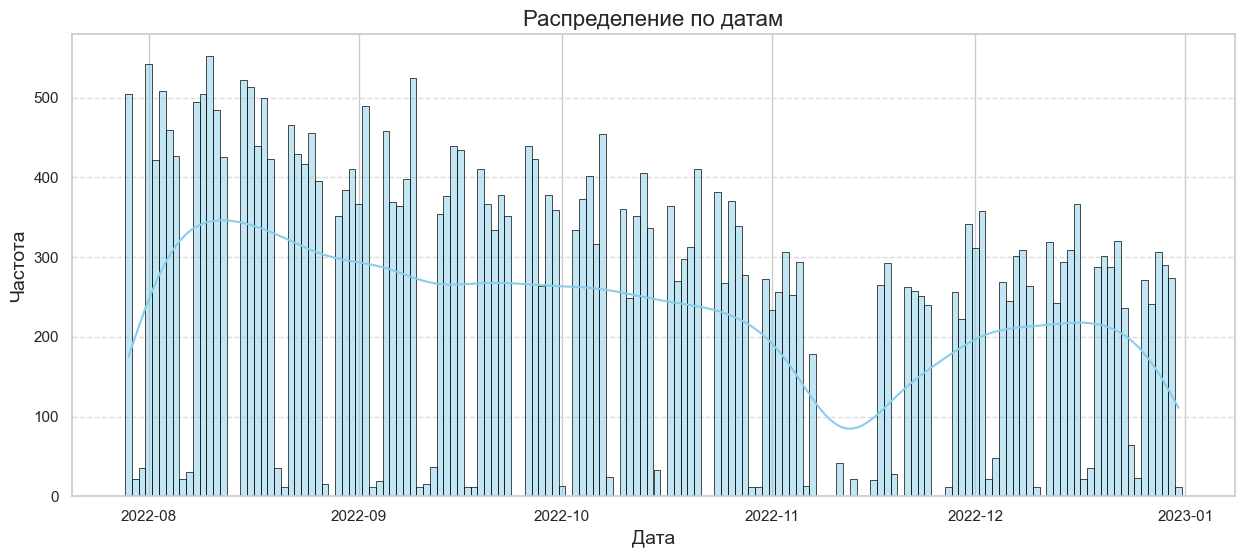

In [14]:
sns.set(style  ="whitegrid", palette = "pastel")
plt.figure(figsize = (15, 6))
ax = sns.histplot(data = train['date'], kde = True, bins = train['date'].nunique(), color = "skyblue", edgecolor = "black")
plt.title("Распределение по датам", fontsize = 16)
plt.xlabel("Дата", fontsize = 14)
plt.ylabel("Частота", fontsize = 14)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.show()

Распределение по minutes в train

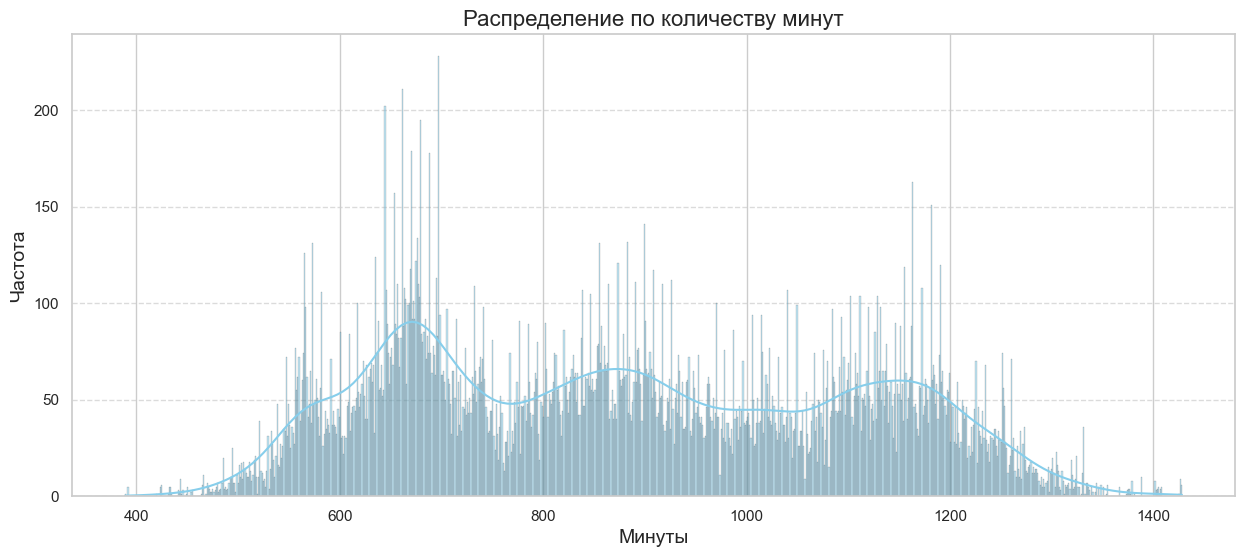

In [15]:
sns.set(style = "whitegrid", palette = "pastel")
plt.figure(figsize = (15, 6))
ax = sns.histplot(data = train['minutes'], kde = True, bins = train['minutes'].nunique(), color = "skyblue", edgecolor = "black")
plt.title("Распределение по количеству минут", fontsize = 16)
plt.xlabel("Минуты", fontsize = 14)
plt.ylabel("Частота", fontsize = 14)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.show()

Распределение по date в test

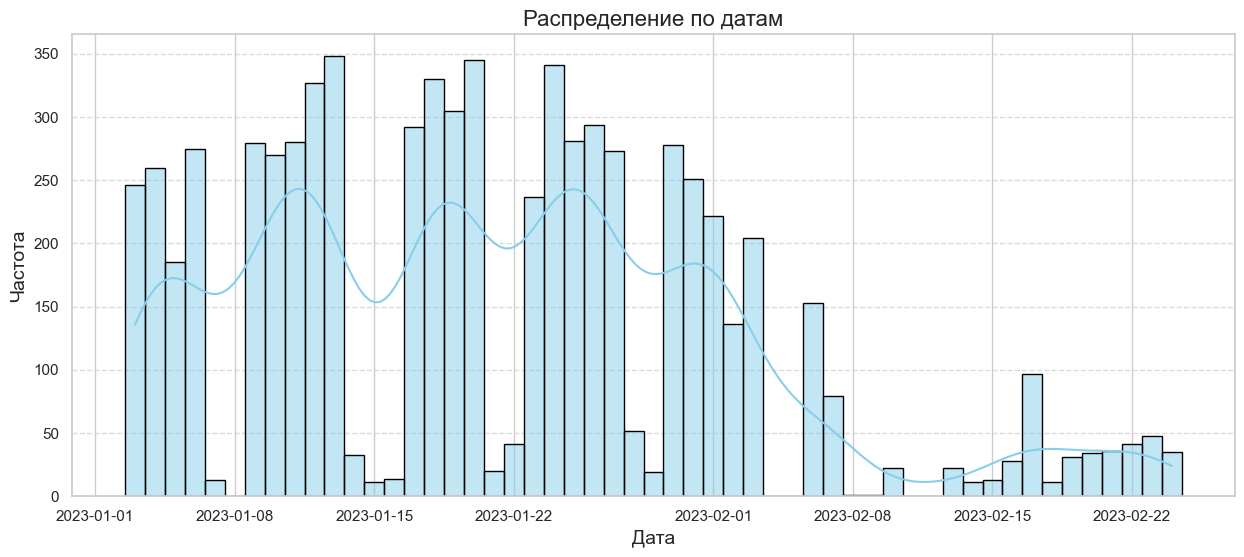

In [16]:
sns.set(style = "whitegrid", palette = "pastel")
plt.figure(figsize = (15, 6))
ax = sns.histplot(data = test['date'], kde = True, bins =test['date'].nunique(), color = "skyblue", edgecolor = "black")
plt.title("Распределение по датам", fontsize = 16)
plt.xlabel("Дата", fontsize = 14)
plt.ylabel("Частота", fontsize = 14)
plt.grid(axis='y', linestyle='--', alpha = 0.7)
plt.show()

Распределение по minutes в test

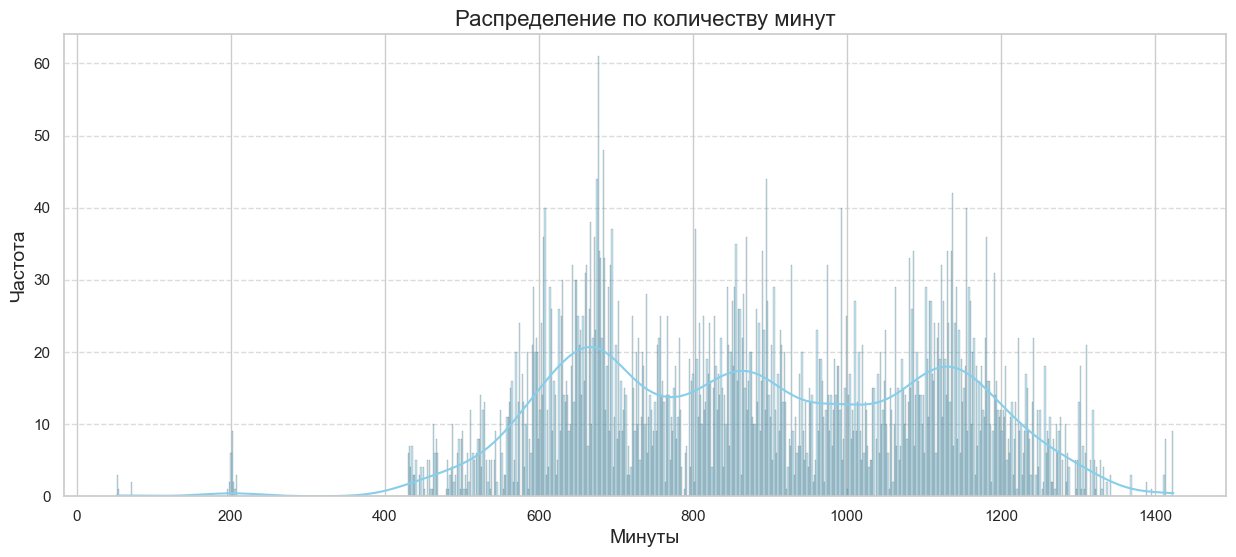

In [17]:
sns.set(style = "whitegrid", palette = "pastel")
plt.figure(figsize = (15, 6))
ax = sns.histplot(data = test['minutes'], kde = True, bins = test['minutes'].nunique(), color = "skyblue", edgecolor = "black")
plt.title("Распределение по количеству минут", fontsize = 16)
plt.xlabel("Минуты", fontsize = 14)
plt.ylabel("Частота", fontsize = 14)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.show()

Выполним агрегацию по признаку user_id

In [18]:
def aggregate_user_data(df):
    """
    Агрегация данных по пользователям, включая количество записей,
    количество уникальных дат, минимальную и максимальную дату.
    Результаты сортируются по количеству записей в возрастающем порядке.
    """
    grp_user = df.groupby('user_id', as_index=False).agg(
        counts=('ts', 'count'),
        date_unique=('date', lambda x: x.nunique()),
        date_min=('date', 'min'),
        date_max=('date', 'max')
    )
    grp_user.sort_values('counts', inplace=True)
    
    return grp_user
aggregate_user_data(train)

,user_id,counts,date_unique,date_min,date_max
4,4,2,1,2022-08-09,2022-08-09
49,51,3,2,2022-12-13,2022-12-16
42,44,4,1,2022-12-28,2022-12-28
50,52,5,1,2022-08-10,2022-08-10
19,21,5,2,2022-12-16,2022-12-28
5,5,10,2,2022-10-26,2022-11-30
28,30,10,2,2022-12-16,2022-12-27
36,38,13,2,2022-11-01,2022-11-03
10,10,17,2,2022-11-30,2022-12-07
8,8,29,2,2022-08-09,2022-11-03


Пользователи которые редко бывали 

In [19]:
n_df = aggregate_user_data(train)
print(n_df[(n_df['counts'] < 3) | (n_df['date_unique'] < 2)])
print('\n--------------------------------------------------------\n')
print('Выбросы в user_id:', list(n_df[(n_df['counts'] < 3) | (n_df['date_unique'] < 2)].user_id.unique()))

    user_id  counts  date_unique    date_min    date_max
4         4       2            1  2022-08-09  2022-08-09
42       44       4            1  2022-12-28  2022-12-28
50       52       5            1  2022-08-10  2022-08-10

--------------------------------------------------------

Выбросы в user_id: [4, 44, 52]


Проверим все ли турникеты в trian присутствуют в test

In [167]:
list_train_gate = train.gate_id.unique()
for i in list_train_gate:
    if i not in test.gate_id.unique():
        print(f'Не нашлось турникета: {i}')

Не нашлось турникета: 0
Не нашлось турникета: 16


Теперь у нас есть записи, которые будут считаться выбросами. 

In [168]:
mask = train.user_id.isin([4,51]) | train.gate_id.isin([0,16]) 
train[mask]

,user_id,gate_id,day,hour,minute,second,minutes,seconds,week,month,weekday,trigg_count,trig_count_by_id
3504,4,8,9,10,9,8,609,36548,32,8,2,505,2
3505,4,8,9,10,9,8,609,36548,32,8,2,505,2
12652,25,0,6,11,16,28,676,40588,36,9,2,369,2
12653,25,0,6,11,16,36,676,40596,36,9,2,369,2
21309,25,16,7,16,44,37,1004,60277,40,10,5,455,2
21310,25,16,7,16,44,38,1004,60278,40,10,5,455,2
33465,51,3,13,13,30,11,810,48611,50,12,2,243,31
34330,51,9,16,13,56,8,836,50168,50,12,5,367,28
34331,51,9,16,13,56,8,836,50168,50,12,5,367,28
36798,56,16,28,14,49,51,889,53391,52,12,3,306,2


In [169]:
train = train[~((train['user_id'].isin([4,44,52])) & (train['gate_id'].isin([0,16])))]

Напишем функцию для добавления в train и test новый признак, который будет отвечать за подсчет количества срабатываний за день и колличество срабатываний для каждого gate_id

In [23]:
def add_count_columns(df):
    """
    Функция добавления новых признаков
    """
    df['trigg_count'] = df.groupby('date')['ts'].transform('count') # количество записей для каждой уникальной даты
    df['trig_count_by_id'] = df.groupby(['date', 'gate_id'])['ts'].transform('count') # количеством записей для каждого gate_id
add_count_columns(train)
add_count_columns(test)

Еще раз проверим пропуски в данных

In [24]:
checklist = ['test', 'train']
for name in checklist:
    pass_value_barh(name)

пропусков не осталось 
пропусков не осталось 


In [25]:
train_0 = train.copy()
test_0 = test.copy()

In [26]:
train = train.drop(['ts', 'date'], axis=1, errors='ignore')
train['week'] = train['week'].astype('int64')
test = test.drop(['ts', 'date'], axis=1, errors='ignore')
test['week'] = test['week'].astype('int64')

Масштабирование данных и выделение target и features

In [27]:
features_train = train.drop('user_id', axis = 1)
features_test = test
target_train = train['user_id']

In [28]:
scaler = StandardScaler()

In [29]:
features_train = pd.DataFrame(scaler.fit_transform(features_train), columns = features_train.columns)
features_test = pd.DataFrame(scaler.transform(features_test), columns = features_test.columns)

Подбор модели, подбор гиперпараметров и обучение модели 

%%time
param_grid = {
    'iterations': [200],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
}

model_cat = CatBoostClassifier(loss_function='MultiClass', 
                               eval_metric='TotalF1',
                               random_seed=12345)

grid_model_cat = GridSearchCV(estimator=model_cat,
                              param_grid=param_grid,
                              cv=3,
                              scoring='accuracy')

grid_model_cat.fit(features_train, target_train)

best_params = grid_model_cat.best_params_
print("Лучшие параметры:", best_params)

best_accuracy = grid_model_cat.best_score_
print("Точность лучшей модели:", best_accuracy)

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}

model_rf = RandomForestClassifier(random_state=12345)

grid_model_rf = GridSearchCV(estimator=model_rf,
                             param_grid=param_grid_rf,
                             cv=3,
                             scoring='accuracy')

grid_model_rf.fit(features_train, target_train)

best_params_rf = grid_model_rf.best_params_
print("Лучшие параметры для RandomForest:", best_params_rf)

best_accuracy_rf = grid_model_rf.best_score_
print("Точность лучшей модели RandomForest:", best_accuracy_rf)


param_grid_knn_extended = {
    'n_neighbors': [3, 5, 7, 10, 15],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40],
}

model_knn_extended = KNeighborsClassifier()

grid_model_knn_extended = GridSearchCV(estimator=model_knn_extended,
                                       param_grid=param_grid_knn_extended,
                                       cv=3,
                                       scoring='accuracy')

grid_model_knn_extended.fit(features_train, target_train)

best_params_knn_extended = grid_model_knn_extended.best_params_
print("Лучшие параметры для KNeighborsClassifier:", best_params_knn_extended)

best_accuracy_knn_extended = grid_model_knn_extended.best_score_
print("Точность лучшей модели KNeighborsClassifier:", best_accuracy_knn_extended)


Моели выдают очень плохой реульат, нужно добавить еще признаков и найти паттерны

In [30]:
train_0['day_period'] = pd.cut(train_0['hour'], bins=[0, 6, 12, 18, 24], labels=['night', 'morning', 'afternoon', 'evening'], right=False)
train_0['visits_per_day_period'] = train_0.groupby(['user_id', 'day_period'])['ts'].transform('count')
train_0['is_weekend'] = (train_0['weekday'] >= 6).astype(int)
train_0['visit_duration'] = train_0.groupby('user_id')['ts'].transform(lambda x: (x.max() - x.min()).total_seconds())
train_0['mean_time_between_visits'] = train_0.groupby('user_id')['ts'].transform(lambda x: x.diff().mean().total_seconds())
train_0['visits_per_month'] = train_0.groupby(['user_id', 'month'])['ts'].transform('count')
train_0['mean_visits_per_day'] = train_0.groupby(['user_id', 'date'])['ts'].transform('count').groupby(train_0['user_id']).transform('mean')
for hour in range(24):
    train_0[f'hour_{hour}_visit'] = (train_0['hour'] == hour).astype(int)

In [31]:
test_0 = pd.merge(test_0, test_user_word, left_index=True, right_index=True)

In [32]:
def second_process_data(df, id_column='user_id'):
    df['day_period'] = pd.cut(df['hour'], bins=[0, 6, 12, 18, 24], labels=['night', 'morning', 'afternoon', 'evening'], right=False)
    df['visits_per_day_period'] = df.groupby([id_column, 'day_period'])['ts'].transform('count')
    df['is_weekend'] = (df['weekday'] >= 6).astype(int)
    df['visit_duration'] = df.groupby(id_column)['ts'].transform(lambda x: (x.max() - x.min()).total_seconds())
    df['mean_time_between_visits'] = df.groupby(id_column)['ts'].transform(lambda x: x.diff().mean().total_seconds())
    df['visits_per_month'] = df.groupby([id_column, 'month'])['ts'].transform('count')
    df['mean_visits_per_day'] = df.groupby([id_column, 'date'])['ts'].transform('count').groupby(df[id_column]).transform('mean')
    for hour in range(24):
        df[f'hour_{hour}_visit'] = (df['hour'] == hour).astype(int)

second_process_data(train_0, id_column='user_id')

second_process_data(test_0, id_column='user_word')

In [33]:
def process_turnstile_patterns(df, timestamp_column='ts'):
    """
    Добавление признаков на основе паттернов прохода через турникет
    """
    df['turnstile_pattern'] = df['date'].astype(str) + '_' + df['hour'].astype(str) + '_' + df['minute'].astype(str)
    df['turnstile_passage_rank'] = df.groupby('turnstile_pattern').cumcount() + 1
    # пропуски заполняются 0 так как можем предполагать, что у пользователя нет предыдущего прохода
    df['time_since_last_turnstile'] = df.groupby('turnstile_pattern')[timestamp_column].diff().dt.total_seconds()
    df['time_since_last_turnstile'] = df['time_since_last_turnstile'].fillna(0)  
    df['mean_time_between_turnstile'] = df.groupby('turnstile_pattern')['time_since_last_turnstile'].transform('mean')
    df['mean_time_between_turnstile'] = df['mean_time_between_turnstile'].fillna(0)  
    df['std_time_between_turnstile'] = df.groupby('turnstile_pattern')['time_since_last_turnstile'].transform('std')
    df['std_time_between_turnstile'] = df['std_time_between_turnstile'].fillna(0)  
process_turnstile_patterns(train_0)
process_turnstile_patterns(test_0)

In [34]:
test_user_word = pd.DataFrame(test_0.user_word)
test_0 = test_0.drop('user_word', axis = 1)

In [35]:
train_0 = train_0.drop(['ts', 'date'], axis=1, errors='ignore')
train_0['week'] = train_0['week'].astype('int64')
test_0 = test_0.drop(['ts', 'date'], axis=1, errors='ignore')
test_0['week'] = test_0['week'].astype('int64')

In [36]:
features_train = train_0.drop('user_id', axis = 1)
features_test = test_0
target_train = train_0['user_id']

In [37]:
le = LabelEncoder()
day_period_mapping = {'night': 0, 'morning': 1, 'afternoon': 2, 'evening': 3}

features_train['day_period'] = features_train['day_period'].astype(str)
features_test['day_period'] = features_test['day_period'].astype(str)
features_train['day_period'] = features_train['day_period'].map(day_period_mapping)
features_test['day_period'] = features_test['day_period'].map(day_period_mapping)

features_train['day_period'] = features_train['day_period'].astype(float)
features_test['day_period'] = features_test['day_period'].astype(float)

combined_data = pd.concat([features_train['day_period'], features_test['day_period']], axis=0)
combined_data_encoded = le.fit_transform(combined_data)

features_train['day_period'] = le.transform(features_train['day_period'])
features_test['day_period'] = le.transform(features_test['day_period'])

In [38]:
features_train = features_train.drop('turnstile_pattern', axis = 1)
features_test = features_test.drop('turnstile_pattern', axis = 1)

In [39]:
numeric_columns = [col for col in features_train.columns]
scaler = StandardScaler()
features_train[numeric_columns] = scaler.fit_transform(features_train[numeric_columns])
features_test[numeric_columns] = scaler.transform(features_test[numeric_columns])

In [186]:
%%time
param_grid = {
    'iterations': [300],
    'learning_rate': [0.05, 0.1], 
    'depth': [2, 4]
}

model_cat = CatBoostClassifier()

grid_model_cat = GridSearchCV(estimator=model_cat,
                              param_grid=param_grid,
                              cv=2,
                              scoring='accuracy')

grid_model_cat.fit(features_train, target_train)

best_params_cat = grid_model_cat.best_params_
print("Лучшие параметры:", best_params_cat)

best_accuracy = grid_model_cat.best_score_
print("Точность лучшей модели:", best_accuracy)

C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


0:	learn: 3.6216359	total: 27.1ms	remaining: 8.11s
1:	learn: 3.4571381	total: 48ms	remaining: 7.14s
2:	learn: 3.3564813	total: 67.3ms	remaining: 6.66s
3:	learn: 3.2517482	total: 87.2ms	remaining: 6.46s
4:	learn: 3.1483009	total: 107ms	remaining: 6.29s
5:	learn: 3.0047451	total: 128ms	remaining: 6.27s
6:	learn: 2.8926763	total: 149ms	remaining: 6.24s
7:	learn: 2.8368512	total: 171ms	remaining: 6.25s
8:	learn: 2.7454695	total: 192ms	remaining: 6.22s
9:	learn: 2.6822211	total: 212ms	remaining: 6.14s
10:	learn: 2.5904247	total: 237ms	remaining: 6.21s
11:	learn: 2.4766330	total: 260ms	remaining: 6.24s
12:	learn: 2.3981988	total: 284ms	remaining: 6.26s
13:	learn: 2.3251292	total: 308ms	remaining: 6.29s
14:	learn: 2.2343612	total: 329ms	remaining: 6.26s
15:	learn: 2.2123431	total: 349ms	remaining: 6.2s
16:	learn: 2.1434252	total: 371ms	remaining: 6.17s
17:	learn: 2.0726513	total: 393ms	remaining: 6.16s
18:	learn: 1.9947150	total: 414ms	remaining: 6.12s
19:	learn: 1.9327190	total: 436ms	remain

163:	learn: 0.2696368	total: 3.74s	remaining: 3.1s
164:	learn: 0.2686255	total: 3.76s	remaining: 3.08s
165:	learn: 0.2676550	total: 3.78s	remaining: 3.05s
166:	learn: 0.2654701	total: 3.8s	remaining: 3.03s
167:	learn: 0.2642844	total: 3.82s	remaining: 3s
168:	learn: 0.2611252	total: 3.85s	remaining: 2.98s
169:	learn: 0.2590247	total: 3.87s	remaining: 2.96s
170:	learn: 0.2559965	total: 3.89s	remaining: 2.94s
171:	learn: 0.2547964	total: 3.91s	remaining: 2.91s
172:	learn: 0.2524490	total: 3.94s	remaining: 2.89s
173:	learn: 0.2519510	total: 3.96s	remaining: 2.87s
174:	learn: 0.2490846	total: 3.98s	remaining: 2.84s
175:	learn: 0.2460981	total: 4s	remaining: 2.82s
176:	learn: 0.2433380	total: 4.03s	remaining: 2.8s
177:	learn: 0.2401627	total: 4.05s	remaining: 2.78s
178:	learn: 0.2371260	total: 4.07s	remaining: 2.75s
179:	learn: 0.2351051	total: 4.09s	remaining: 2.73s
180:	learn: 0.2343549	total: 4.12s	remaining: 2.71s
181:	learn: 0.2321383	total: 4.14s	remaining: 2.69s
182:	learn: 0.2294054

29:	learn: 1.4430209	total: 668ms	remaining: 6.01s
30:	learn: 1.4034971	total: 691ms	remaining: 5.99s
31:	learn: 1.3638883	total: 711ms	remaining: 5.96s
32:	learn: 1.3339674	total: 731ms	remaining: 5.91s
33:	learn: 1.3004504	total: 752ms	remaining: 5.88s
34:	learn: 1.2691964	total: 772ms	remaining: 5.85s
35:	learn: 1.2409069	total: 792ms	remaining: 5.81s
36:	learn: 1.2134187	total: 815ms	remaining: 5.79s
37:	learn: 1.1872025	total: 835ms	remaining: 5.76s
38:	learn: 1.1625317	total: 861ms	remaining: 5.76s
39:	learn: 1.1397489	total: 894ms	remaining: 5.81s
40:	learn: 1.1126232	total: 924ms	remaining: 5.83s
41:	learn: 1.0862530	total: 949ms	remaining: 5.83s
42:	learn: 1.0627270	total: 975ms	remaining: 5.83s
43:	learn: 1.0456236	total: 1s	remaining: 5.82s
44:	learn: 1.0263386	total: 1.02s	remaining: 5.79s
45:	learn: 1.0051296	total: 1.05s	remaining: 5.78s
46:	learn: 0.9836132	total: 1.07s	remaining: 5.76s
47:	learn: 0.9624122	total: 1.09s	remaining: 5.74s
48:	learn: 0.9447948	total: 1.12s	

192:	learn: 0.2129448	total: 4.39s	remaining: 2.43s
193:	learn: 0.2113637	total: 4.41s	remaining: 2.41s
194:	learn: 0.2097074	total: 4.44s	remaining: 2.39s
195:	learn: 0.2086119	total: 4.46s	remaining: 2.37s
196:	learn: 0.2072567	total: 4.48s	remaining: 2.34s
197:	learn: 0.2046020	total: 4.5s	remaining: 2.32s
198:	learn: 0.2042858	total: 4.52s	remaining: 2.3s
199:	learn: 0.2030416	total: 4.55s	remaining: 2.27s
200:	learn: 0.2028284	total: 4.57s	remaining: 2.25s
201:	learn: 0.2025763	total: 4.59s	remaining: 2.23s
202:	learn: 0.2013008	total: 4.61s	remaining: 2.2s
203:	learn: 0.1997276	total: 4.63s	remaining: 2.18s
204:	learn: 0.1988972	total: 4.66s	remaining: 2.16s
205:	learn: 0.1987867	total: 4.68s	remaining: 2.13s
206:	learn: 0.1965109	total: 4.7s	remaining: 2.11s
207:	learn: 0.1963752	total: 4.72s	remaining: 2.09s
208:	learn: 0.1949398	total: 4.74s	remaining: 2.06s
209:	learn: 0.1941678	total: 4.76s	remaining: 2.04s
210:	learn: 0.1935362	total: 4.78s	remaining: 2.02s
211:	learn: 0.19

57:	learn: 0.3819226	total: 1.31s	remaining: 5.49s
58:	learn: 0.3727771	total: 1.34s	remaining: 5.47s
59:	learn: 0.3634836	total: 1.36s	remaining: 5.46s
60:	learn: 0.3538024	total: 1.39s	remaining: 5.43s
61:	learn: 0.3418679	total: 1.41s	remaining: 5.4s
62:	learn: 0.3353030	total: 1.43s	remaining: 5.38s
63:	learn: 0.3311389	total: 1.45s	remaining: 5.34s
64:	learn: 0.3279782	total: 1.47s	remaining: 5.31s
65:	learn: 0.3237269	total: 1.49s	remaining: 5.28s
66:	learn: 0.3152075	total: 1.51s	remaining: 5.27s
67:	learn: 0.3051800	total: 1.54s	remaining: 5.26s
68:	learn: 0.3041304	total: 1.56s	remaining: 5.23s
69:	learn: 0.2977665	total: 1.58s	remaining: 5.2s
70:	learn: 0.2927067	total: 1.6s	remaining: 5.17s
71:	learn: 0.2904436	total: 1.62s	remaining: 5.14s
72:	learn: 0.2831276	total: 1.65s	remaining: 5.13s
73:	learn: 0.2747805	total: 1.68s	remaining: 5.12s
74:	learn: 0.2705456	total: 1.7s	remaining: 5.09s
75:	learn: 0.2681070	total: 1.72s	remaining: 5.07s
76:	learn: 0.2654848	total: 1.74s	r

224:	learn: 0.0748581	total: 4.96s	remaining: 1.65s
225:	learn: 0.0747941	total: 4.98s	remaining: 1.63s
226:	learn: 0.0747880	total: 5s	remaining: 1.61s
227:	learn: 0.0740615	total: 5.03s	remaining: 1.59s
228:	learn: 0.0740503	total: 5.05s	remaining: 1.56s
229:	learn: 0.0740434	total: 5.07s	remaining: 1.54s
230:	learn: 0.0740349	total: 5.09s	remaining: 1.52s
231:	learn: 0.0730332	total: 5.11s	remaining: 1.5s
232:	learn: 0.0725253	total: 5.14s	remaining: 1.48s
233:	learn: 0.0725160	total: 5.16s	remaining: 1.46s
234:	learn: 0.0724610	total: 5.18s	remaining: 1.43s
235:	learn: 0.0724546	total: 5.2s	remaining: 1.41s
236:	learn: 0.0724490	total: 5.22s	remaining: 1.39s
237:	learn: 0.0715223	total: 5.25s	remaining: 1.37s
238:	learn: 0.0713450	total: 5.27s	remaining: 1.34s
239:	learn: 0.0698899	total: 5.29s	remaining: 1.32s
240:	learn: 0.0698844	total: 5.31s	remaining: 1.3s
241:	learn: 0.0698782	total: 5.33s	remaining: 1.28s
242:	learn: 0.0698689	total: 5.36s	remaining: 1.26s
243:	learn: 0.0698

91:	learn: 0.1975055	total: 2.25s	remaining: 5.08s
92:	learn: 0.1970260	total: 2.27s	remaining: 5.06s
93:	learn: 0.1965012	total: 2.29s	remaining: 5.03s
94:	learn: 0.1962142	total: 2.32s	remaining: 5s
95:	learn: 0.1918572	total: 2.34s	remaining: 4.97s
96:	learn: 0.1896432	total: 2.36s	remaining: 4.95s
97:	learn: 0.1864509	total: 2.39s	remaining: 4.92s
98:	learn: 0.1823560	total: 2.41s	remaining: 4.9s
99:	learn: 0.1794104	total: 2.44s	remaining: 4.87s
100:	learn: 0.1758084	total: 2.46s	remaining: 4.85s
101:	learn: 0.1751678	total: 2.49s	remaining: 4.83s
102:	learn: 0.1718169	total: 2.51s	remaining: 4.8s
103:	learn: 0.1692430	total: 2.53s	remaining: 4.78s
104:	learn: 0.1653830	total: 2.56s	remaining: 4.75s
105:	learn: 0.1651793	total: 2.58s	remaining: 4.72s
106:	learn: 0.1639391	total: 2.6s	remaining: 4.69s
107:	learn: 0.1637106	total: 2.62s	remaining: 4.66s
108:	learn: 0.1635638	total: 2.64s	remaining: 4.63s
109:	learn: 0.1632192	total: 2.66s	remaining: 4.6s
110:	learn: 0.1621472	total:

256:	learn: 0.0677914	total: 5.99s	remaining: 1s
257:	learn: 0.0677849	total: 6.01s	remaining: 979ms
258:	learn: 0.0677786	total: 6.04s	remaining: 956ms
259:	learn: 0.0677724	total: 6.06s	remaining: 933ms
260:	learn: 0.0674682	total: 6.08s	remaining: 909ms
261:	learn: 0.0674623	total: 6.11s	remaining: 886ms
262:	learn: 0.0674450	total: 6.13s	remaining: 862ms
263:	learn: 0.0674279	total: 6.15s	remaining: 839ms
264:	learn: 0.0674236	total: 6.17s	remaining: 815ms
265:	learn: 0.0666279	total: 6.2s	remaining: 792ms
266:	learn: 0.0665927	total: 6.22s	remaining: 769ms
267:	learn: 0.0665871	total: 6.24s	remaining: 745ms
268:	learn: 0.0665816	total: 6.26s	remaining: 721ms
269:	learn: 0.0652609	total: 6.28s	remaining: 698ms
270:	learn: 0.0652500	total: 6.3s	remaining: 675ms
271:	learn: 0.0652296	total: 6.33s	remaining: 651ms
272:	learn: 0.0652243	total: 6.35s	remaining: 628ms
273:	learn: 0.0652191	total: 6.37s	remaining: 604ms
274:	learn: 0.0651870	total: 6.39s	remaining: 581ms
275:	learn: 0.065

119:	learn: 0.1293044	total: 6.08s	remaining: 9.12s
120:	learn: 0.1271744	total: 6.13s	remaining: 9.07s
121:	learn: 0.1265405	total: 6.18s	remaining: 9.02s
122:	learn: 0.1264107	total: 6.24s	remaining: 8.98s
123:	learn: 0.1247730	total: 6.29s	remaining: 8.93s
124:	learn: 0.1240404	total: 6.34s	remaining: 8.88s
125:	learn: 0.1214850	total: 6.39s	remaining: 8.83s
126:	learn: 0.1197312	total: 6.44s	remaining: 8.78s
127:	learn: 0.1180756	total: 6.5s	remaining: 8.73s
128:	learn: 0.1174660	total: 6.55s	remaining: 8.68s
129:	learn: 0.1155496	total: 6.6s	remaining: 8.63s
130:	learn: 0.1134769	total: 6.65s	remaining: 8.58s
131:	learn: 0.1123899	total: 6.7s	remaining: 8.52s
132:	learn: 0.1120180	total: 6.75s	remaining: 8.47s
133:	learn: 0.1116483	total: 6.79s	remaining: 8.42s
134:	learn: 0.1115178	total: 6.85s	remaining: 8.37s
135:	learn: 0.1096292	total: 6.89s	remaining: 8.31s
136:	learn: 0.1084085	total: 6.95s	remaining: 8.27s
137:	learn: 0.1083585	total: 7s	remaining: 8.21s
138:	learn: 0.1082

278:	learn: 0.0517137	total: 14.2s	remaining: 1.07s
279:	learn: 0.0517066	total: 14.3s	remaining: 1.02s
280:	learn: 0.0516873	total: 14.3s	remaining: 969ms
281:	learn: 0.0516818	total: 14.4s	remaining: 918ms
282:	learn: 0.0516772	total: 14.4s	remaining: 867ms
283:	learn: 0.0516703	total: 14.5s	remaining: 816ms
284:	learn: 0.0516658	total: 14.5s	remaining: 765ms
285:	learn: 0.0510234	total: 14.6s	remaining: 715ms
286:	learn: 0.0510048	total: 14.7s	remaining: 664ms
287:	learn: 0.0509122	total: 14.7s	remaining: 613ms
288:	learn: 0.0507570	total: 14.8s	remaining: 562ms
289:	learn: 0.0502187	total: 14.8s	remaining: 511ms
290:	learn: 0.0502123	total: 14.9s	remaining: 459ms
291:	learn: 0.0499303	total: 14.9s	remaining: 408ms
292:	learn: 0.0499169	total: 15s	remaining: 357ms
293:	learn: 0.0499024	total: 15s	remaining: 306ms
294:	learn: 0.0489073	total: 15.1s	remaining: 255ms
295:	learn: 0.0489031	total: 15.1s	remaining: 204ms
296:	learn: 0.0488970	total: 15.2s	remaining: 153ms
297:	learn: 0.04

140:	learn: 0.1066548	total: 7.57s	remaining: 8.54s
141:	learn: 0.1061795	total: 7.62s	remaining: 8.48s
142:	learn: 0.1059092	total: 7.68s	remaining: 8.43s
143:	learn: 0.1056320	total: 7.74s	remaining: 8.38s
144:	learn: 0.1039138	total: 7.79s	remaining: 8.33s
145:	learn: 0.1037456	total: 7.84s	remaining: 8.28s
146:	learn: 0.1031790	total: 7.9s	remaining: 8.22s
147:	learn: 0.1030854	total: 7.96s	remaining: 8.17s
148:	learn: 0.1026152	total: 8.01s	remaining: 8.12s
149:	learn: 0.1024092	total: 8.06s	remaining: 8.06s
150:	learn: 0.1023533	total: 8.12s	remaining: 8.01s
151:	learn: 0.1020583	total: 8.17s	remaining: 7.96s
152:	learn: 0.1014224	total: 8.22s	remaining: 7.9s
153:	learn: 0.1005682	total: 8.28s	remaining: 7.85s
154:	learn: 0.0998788	total: 8.34s	remaining: 7.8s
155:	learn: 0.0998405	total: 8.39s	remaining: 7.74s
156:	learn: 0.0981388	total: 8.44s	remaining: 7.69s
157:	learn: 0.0968396	total: 8.5s	remaining: 7.64s
158:	learn: 0.0968120	total: 8.57s	remaining: 7.6s
159:	learn: 0.096

299:	learn: 0.0544530	total: 16s	remaining: 0us
0:	learn: 2.6522089	total: 55.4ms	remaining: 16.6s
1:	learn: 2.0019871	total: 110ms	remaining: 16.4s
2:	learn: 1.6396559	total: 164ms	remaining: 16.2s
3:	learn: 1.4704604	total: 217ms	remaining: 16s
4:	learn: 1.2804584	total: 270ms	remaining: 15.9s
5:	learn: 1.1466533	total: 321ms	remaining: 15.7s
6:	learn: 1.0331752	total: 375ms	remaining: 15.7s
7:	learn: 0.9557892	total: 428ms	remaining: 15.6s
8:	learn: 0.8489223	total: 480ms	remaining: 15.5s
9:	learn: 0.7721062	total: 532ms	remaining: 15.4s
10:	learn: 0.7006631	total: 584ms	remaining: 15.3s
11:	learn: 0.6489488	total: 637ms	remaining: 15.3s
12:	learn: 0.6004784	total: 692ms	remaining: 15.3s
13:	learn: 0.5625737	total: 752ms	remaining: 15.4s
14:	learn: 0.5239870	total: 804ms	remaining: 15.3s
15:	learn: 0.4897273	total: 858ms	remaining: 15.2s
16:	learn: 0.4595531	total: 911ms	remaining: 15.2s
17:	learn: 0.4311275	total: 963ms	remaining: 15.1s
18:	learn: 0.4100715	total: 1.02s	remaining: 

163:	learn: 0.0390842	total: 8.66s	remaining: 7.18s
164:	learn: 0.0390781	total: 8.72s	remaining: 7.13s
165:	learn: 0.0390705	total: 8.77s	remaining: 7.08s
166:	learn: 0.0376251	total: 8.82s	remaining: 7.03s
167:	learn: 0.0376161	total: 8.88s	remaining: 6.97s
168:	learn: 0.0375775	total: 8.93s	remaining: 6.92s
169:	learn: 0.0372732	total: 8.98s	remaining: 6.87s
170:	learn: 0.0364217	total: 9.04s	remaining: 6.82s
171:	learn: 0.0361437	total: 9.09s	remaining: 6.76s
172:	learn: 0.0359686	total: 9.14s	remaining: 6.71s
173:	learn: 0.0359627	total: 9.19s	remaining: 6.66s
174:	learn: 0.0359549	total: 9.25s	remaining: 6.61s
175:	learn: 0.0359468	total: 9.3s	remaining: 6.55s
176:	learn: 0.0359393	total: 9.35s	remaining: 6.5s
177:	learn: 0.0359340	total: 9.41s	remaining: 6.45s
178:	learn: 0.0359288	total: 9.46s	remaining: 6.39s
179:	learn: 0.0359238	total: 9.51s	remaining: 6.34s
180:	learn: 0.0359162	total: 9.56s	remaining: 6.29s
181:	learn: 0.0347846	total: 9.62s	remaining: 6.23s
182:	learn: 0.

25:	learn: 0.2930897	total: 1.41s	remaining: 14.8s
26:	learn: 0.2829937	total: 1.46s	remaining: 14.8s
27:	learn: 0.2706001	total: 1.51s	remaining: 14.7s
28:	learn: 0.2559772	total: 1.57s	remaining: 14.7s
29:	learn: 0.2440717	total: 1.62s	remaining: 14.6s
30:	learn: 0.2390359	total: 1.67s	remaining: 14.5s
31:	learn: 0.2301955	total: 1.73s	remaining: 14.5s
32:	learn: 0.2171779	total: 1.78s	remaining: 14.4s
33:	learn: 0.2144090	total: 1.83s	remaining: 14.4s
34:	learn: 0.2104263	total: 1.89s	remaining: 14.3s
35:	learn: 0.2021188	total: 1.94s	remaining: 14.2s
36:	learn: 0.1937671	total: 2s	remaining: 14.2s
37:	learn: 0.1925944	total: 2.05s	remaining: 14.1s
38:	learn: 0.1816426	total: 2.11s	remaining: 14.1s
39:	learn: 0.1733422	total: 2.16s	remaining: 14s
40:	learn: 0.1643594	total: 2.22s	remaining: 14s
41:	learn: 0.1599334	total: 2.27s	remaining: 13.9s
42:	learn: 0.1540169	total: 2.32s	remaining: 13.9s
43:	learn: 0.1531865	total: 2.37s	remaining: 13.8s
44:	learn: 0.1467070	total: 2.42s	rema

187:	learn: 0.0377284	total: 10s	remaining: 5.96s
188:	learn: 0.0377239	total: 10.1s	remaining: 5.91s
189:	learn: 0.0377187	total: 10.1s	remaining: 5.85s
190:	learn: 0.0377140	total: 10.2s	remaining: 5.8s
191:	learn: 0.0369774	total: 10.2s	remaining: 5.75s
192:	learn: 0.0369689	total: 10.3s	remaining: 5.7s
193:	learn: 0.0360389	total: 10.3s	remaining: 5.64s
194:	learn: 0.0347510	total: 10.4s	remaining: 5.59s
195:	learn: 0.0347447	total: 10.4s	remaining: 5.54s
196:	learn: 0.0347398	total: 10.5s	remaining: 5.49s
197:	learn: 0.0347316	total: 10.6s	remaining: 5.44s
198:	learn: 0.0347273	total: 10.6s	remaining: 5.38s
199:	learn: 0.0334530	total: 10.6s	remaining: 5.32s
200:	learn: 0.0334483	total: 10.7s	remaining: 5.27s
201:	learn: 0.0329181	total: 10.8s	remaining: 5.22s
202:	learn: 0.0329140	total: 10.8s	remaining: 5.16s
203:	learn: 0.0318069	total: 10.9s	remaining: 5.11s
204:	learn: 0.0318005	total: 10.9s	remaining: 5.05s
205:	learn: 0.0317523	total: 11s	remaining: 5s
206:	learn: 0.0317459

50:	learn: 0.3779058	total: 2.52s	remaining: 12.3s
51:	learn: 0.3689089	total: 2.56s	remaining: 12.2s
52:	learn: 0.3561210	total: 2.61s	remaining: 12.2s
53:	learn: 0.3464709	total: 2.66s	remaining: 12.1s
54:	learn: 0.3423129	total: 2.71s	remaining: 12.1s
55:	learn: 0.3342927	total: 2.76s	remaining: 12s
56:	learn: 0.3311390	total: 2.81s	remaining: 12s
57:	learn: 0.3204213	total: 2.86s	remaining: 11.9s
58:	learn: 0.3100679	total: 2.91s	remaining: 11.9s
59:	learn: 0.3032621	total: 2.96s	remaining: 11.8s
60:	learn: 0.2961357	total: 3.01s	remaining: 11.8s
61:	learn: 0.2875143	total: 3.06s	remaining: 11.7s
62:	learn: 0.2858734	total: 3.1s	remaining: 11.7s
63:	learn: 0.2779051	total: 3.15s	remaining: 11.6s
64:	learn: 0.2683473	total: 3.2s	remaining: 11.6s
65:	learn: 0.2656696	total: 3.25s	remaining: 11.5s
66:	learn: 0.2626177	total: 3.29s	remaining: 11.4s
67:	learn: 0.2556125	total: 3.34s	remaining: 11.4s
68:	learn: 0.2531477	total: 3.39s	remaining: 11.3s
69:	learn: 0.2511085	total: 3.43s	rem

213:	learn: 0.0590184	total: 10.4s	remaining: 4.18s
214:	learn: 0.0590135	total: 10.5s	remaining: 4.13s
215:	learn: 0.0590032	total: 10.5s	remaining: 4.08s
216:	learn: 0.0581204	total: 10.6s	remaining: 4.04s
217:	learn: 0.0581136	total: 10.6s	remaining: 3.99s
218:	learn: 0.0573454	total: 10.7s	remaining: 3.94s
219:	learn: 0.0573388	total: 10.7s	remaining: 3.89s
220:	learn: 0.0573345	total: 10.8s	remaining: 3.84s
221:	learn: 0.0565512	total: 10.8s	remaining: 3.8s
222:	learn: 0.0565418	total: 10.9s	remaining: 3.75s
223:	learn: 0.0558894	total: 10.9s	remaining: 3.7s
224:	learn: 0.0551490	total: 11s	remaining: 3.65s
225:	learn: 0.0551448	total: 11s	remaining: 3.6s
226:	learn: 0.0549806	total: 11s	remaining: 3.55s
227:	learn: 0.0549058	total: 11.1s	remaining: 3.5s
228:	learn: 0.0539740	total: 11.1s	remaining: 3.45s
229:	learn: 0.0535523	total: 11.2s	remaining: 3.4s
230:	learn: 0.0534739	total: 11.2s	remaining: 3.35s
231:	learn: 0.0534680	total: 11.3s	remaining: 3.31s
232:	learn: 0.0534629	t

In [187]:
%%time
param_grid_knn_extended = {
    'n_neighbors': [10, 15, 20, 40],
    'p': [1],
    'algorithm': ['auto']
}

model_knn_extended = KNeighborsClassifier(n_jobs = 3)

grid_model_knn_extended = GridSearchCV(estimator=model_knn_extended,
                                       param_grid=param_grid_knn_extended,
                                       cv=2,
                                       scoring='accuracy')

grid_model_knn_extended.fit(features_train, target_train)

best_params_knn_extended = grid_model_knn_extended.best_params_
print("Лучшие параметры для KNeighborsClassifier:", best_params_knn_extended)

best_accuracy_knn_extended = grid_model_knn_extended.best_score_
print("Точность лучшей модели KNeighborsClassifier:", best_accuracy_knn_extended)

C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Лучшие параметры для KNeighborsClassifier: {'algorithm': 'auto', 'n_neighbors': 20, 'p': 1}
Точность лучшей модели KNeighborsClassifier: 0.7827848461155733
CPU times: total: 1min 11s
Wall time: 9.53 s


In [188]:
model_cat = CatBoostClassifier(depth = 2,
                               iterations = 300,
                               learning_rate = 0.1)
model_knn = KNeighborsClassifier(algorithm = 'auto',
                                 n_neighbors = 20,
                                 p = 1,
                                 n_jobs = 3)
model_cat.fit(features_train, target_train)
model_knn.fit(features_train, target_train)
predictions_cat = model_cat.predict(features_test)
predictions_knn = model_knn.predict(features_test)

0:	learn: 3.4977575	total: 46.3ms	remaining: 13.9s
1:	learn: 3.1214958	total: 90.6ms	remaining: 13.5s
2:	learn: 2.7719163	total: 143ms	remaining: 14.2s
3:	learn: 2.4787064	total: 192ms	remaining: 14.2s
4:	learn: 2.2457955	total: 240ms	remaining: 14.1s
5:	learn: 2.0669792	total: 289ms	remaining: 14.2s
6:	learn: 1.9164329	total: 333ms	remaining: 13.9s
7:	learn: 1.7973756	total: 381ms	remaining: 13.9s
8:	learn: 1.6492792	total: 426ms	remaining: 13.8s
9:	learn: 1.5715728	total: 474ms	remaining: 13.7s
10:	learn: 1.4834208	total: 519ms	remaining: 13.6s
11:	learn: 1.3918986	total: 565ms	remaining: 13.6s
12:	learn: 1.3057583	total: 611ms	remaining: 13.5s
13:	learn: 1.2267162	total: 656ms	remaining: 13.4s
14:	learn: 1.1845606	total: 705ms	remaining: 13.4s
15:	learn: 1.1317507	total: 753ms	remaining: 13.4s
16:	learn: 1.0929488	total: 799ms	remaining: 13.3s
17:	learn: 1.0471667	total: 854ms	remaining: 13.4s
18:	learn: 0.9923360	total: 902ms	remaining: 13.3s
19:	learn: 0.9415024	total: 950ms	remai

165:	learn: 0.0795127	total: 7.84s	remaining: 6.33s
166:	learn: 0.0792355	total: 7.89s	remaining: 6.28s
167:	learn: 0.0792180	total: 7.96s	remaining: 6.25s
168:	learn: 0.0774872	total: 8.02s	remaining: 6.22s
169:	learn: 0.0774644	total: 8.07s	remaining: 6.17s
170:	learn: 0.0774517	total: 8.11s	remaining: 6.12s
171:	learn: 0.0774404	total: 8.15s	remaining: 6.07s
172:	learn: 0.0774069	total: 8.2s	remaining: 6.02s
173:	learn: 0.0773887	total: 8.24s	remaining: 5.96s
174:	learn: 0.0757577	total: 8.29s	remaining: 5.92s
175:	learn: 0.0757421	total: 8.33s	remaining: 5.87s
176:	learn: 0.0739543	total: 8.38s	remaining: 5.82s
177:	learn: 0.0724380	total: 8.42s	remaining: 5.77s
178:	learn: 0.0723163	total: 8.47s	remaining: 5.72s
179:	learn: 0.0723048	total: 8.51s	remaining: 5.67s
180:	learn: 0.0722884	total: 8.56s	remaining: 5.63s
181:	learn: 0.0717175	total: 8.6s	remaining: 5.58s
182:	learn: 0.0706772	total: 8.65s	remaining: 5.53s
183:	learn: 0.0704233	total: 8.7s	remaining: 5.48s
184:	learn: 0.0

In [189]:
predictions_df = pd.DataFrame({
    'predictions_cat': predictions_cat.ravel(),
    'predictions_knn': predictions_knn.ravel()
})
result_df_proba = pd.concat([test_user_word, predictions_df], axis=1)

In [190]:
result_df_proba.head(25)

,user_word,predictions_cat,predictions_knn
0,gini,57,42
1,gini,57,42
2,gini,57,42
3,gini,57,42
4,gini,57,42
5,epsilon,35,42
6,epsilon,35,42
7,epsilon,35,42
8,epsilon,35,42
9,epsilon,35,42


In [191]:
print('user_word: ', result_df_proba.user_word.nunique())
print('predictions_cat: ', result_df_proba.predictions_cat.nunique())
print('predictions_knn: ', result_df_proba.predictions_knn.nunique())

user_word:  34
predictions_cat:  15
predictions_knn:  13


In [192]:
result_df_grouped = result_df_proba.groupby('user_word')[['predictions_cat', 'predictions_knn']].agg(lambda x: x.value_counts()).reset_index()

C:\Users\kil_a\AppData\Local\Temp\ipykernel_3172\454487092.py:1: FutureWarning: ['predictions_knn'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  result_df_grouped = result_df_proba.groupby('user_word')[['predictions_cat', 'predictions_knn']].agg(lambda x: x.value_counts()).reset_index()


In [193]:
result_df_grouped

,user_word,predictions_cat
0,aucroc,41
1,binary,393
2,blue,12
3,categorical,259
4,coefficient,65
5,collinear,329
6,distributed,123
7,epsilon,371
8,f1,761
9,fit,193


In [195]:
result_df_grouped['preds'] = result_df_grouped['predictions_cat']
result_df_grouped.drop(['predictions_cat'], axis=1, inplace=True, errors='raise')

In [196]:
result_df_grouped

,user_word,preds
0,aucroc,41
1,binary,393
2,blue,12
3,categorical,259
4,coefficient,65
5,collinear,329
6,distributed,123
7,epsilon,371
8,f1,761
9,fit,193


In [50]:
result_df_grouped = result_df_grouped.reset_index(drop=True)

In [51]:
result_df_grouped.to_csv('answer.csv', index=False)

In [52]:
code = """
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
"""

file_path = 'requirements.txt'

with open(file_path, 'w') as file:
    file.write(code)